# RTM Example
We will perform RTM using the following steps:
1. Read the 10m resampled models output from the FWI notebook
    * true model
    * initial model
    * fwi model
2. Visualize the models 
3. Build a small local compute cluster (2 workers)
4. Create list of shot locations 
5. Define the migrateshot , timemute! and stacking functions
6. Run the migration and then stack the data we wrote to disk
7. Perform a little post migration filtering
8. Visualize Results

#### Note on runtime
This notebook takes approximately 1/2 hour to run for 24 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

## Add required packages

In [2]:
using Distributed, PyPlot, Jets, JetPack, JetPackDSP, Printf

## Record time for start of notebook

In [3]:
time_beg = time()

1.602866748879412e9

## 1. Read the models output from the FWI notebook

In [4]:
file1 = "../50_fwi/marmousi_resampled_10m_349x1701_vtrue.bin"

nz,nx = 349,1701
dz,dx = 10.0,10.0

v1_orig = read!(file1, Array{Float32}(undef,nz,nx));

####  Apply a 3x3 convolutional smoother
We perform the RTM migration in a slightly smoothed model.

In [5]:
ns = 21
P = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=true)
M = JopMix(range(P), (7,7))
R = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=false)

s1 = R' ∘ M ∘ P * (1 ./ v1_orig)

v1 = 1 ./(s1);

## 2. Visualize the model

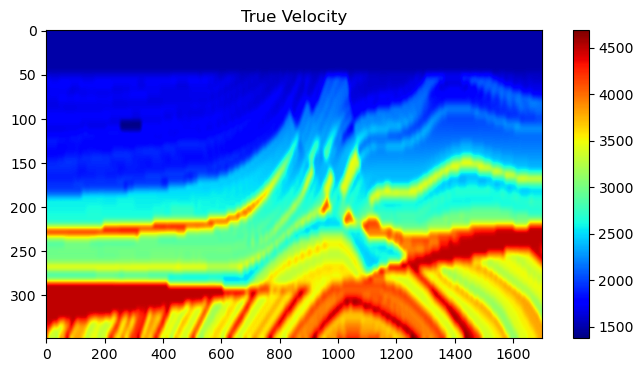

(vmin, vmax) = (1377.2083f0, 4688.674f0)


In [10]:
vmin,vmax = extrema(v1_orig)
@show vmin,vmax;
figure(figsize=(8,4)); clf()

imshow(v1,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("True Velocity");

## 3. Build a small local compute cluster (2 workers) 

#### Setup OMP environment variables for the cluster
Note we need to do this because we are using multiple workers on the same physical node, and without setting up thread affinity the modeling will be *incredibly* slow.

Because we set `ENV["OMP_DISPLAY_ENV"] = "true"`, when the "cluster spins up" by calling `addprocs()` below you will see the OMP environment printed out on each worker. You can verify that half of the threads are assigned to the first half of the physical cpus, and similarly for the second half, by looking at the value of the `OMP_PLACES` variable.

In [11]:
nthread = Sys.CPU_THREADS
ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread,2))" 
addprocs(2)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, nthread
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, nthread) = (0, 7, 16)
(place1, place2, nthread) = (8, 15, 16)


In [12]:
@everywhere using DistributedArrays, DistributedJets, DistributedOperations, Jets, JetPack, WaveFD, JetPackWaveFD, Random, LinearAlgebra, Schedulers

      From worker 2:	
      From worker 2:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 2:	  _OPENMP = '201511'
      From worker 2:	  OMP_DYNAMIC = 'FALSE'
      From worker 2:	  OMP_NESTED = 'FALSE'
      From worker 2:	  OMP_NUM_THREADS = '8'
      From worker 2:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 2:	  OMP_PROC_BIND = 'CLOSE'
      From worker 2:	  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7}'
      From worker 2:	  OMP_STACKSIZE = '0'
      From worker 2:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 2:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 2:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 2:	  OMP_CANCELLATION = 'FALSE'
      From worker 2:	  OMP_DEFAULT_DEVICE = '0'
      From worker 2:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 2:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 2:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From worker 2:	OPENMP DISPLAY ENVIRONMENT END
      From worker 3:	
      From worker 3

## 4. Create list of shot locations 
We use 100 shot locations, many times than our FWI example, and run at significantly higher frequency. 

In [13]:
nshots = 100
sx = round.(Int,collect(range(0,stop=(nx-1)*dx,length=nshots)))
@show nshots;
@show sx;

nshots = 100
sx = [0, 172, 343, 515, 687, 859, 1030, 1202, 1374, 1545, 1717, 1889, 2061, 2232, 2404, 2576, 2747, 2919, 3091, 3263, 3434, 3606, 3778, 3949, 4121, 4293, 4465, 4636, 4808, 4980, 5152, 5323, 5495, 5667, 5838, 6010, 6182, 6354, 6525, 6697, 6869, 7040, 7212, 7384, 7556, 7727, 7899, 8071, 8242, 8414, 8586, 8758, 8929, 9101, 9273, 9444, 9616, 9788, 9960, 10131, 10303, 10475, 10646, 10818, 10990, 11162, 11333, 11505, 11677, 11848, 12020, 12192, 12364, 12535, 12707, 12879, 13051, 13222, 13394, 13566, 13737, 13909, 14081, 14253, 14424, 14596, 14768, 14939, 15111, 15283, 15455, 15626, 15798, 15970, 16141, 16313, 16485, 16657, 16828, 17000]


## 5. Define the migrateshot and stack functions
#### migrateshot is the writes the image and illumination files to our scratch disk
#### stack reads in the specified shot from disk and stacks them

#### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [14]:
@everywhere scratch = "/mnt/scratch"
@assert isdir(scratch)

In [15]:
@everywhere begin
    ntrec = 3001
    dtrec = 0.002
    dtmod = 0.001
end

#### Build the migrate shot function which is the work that needs to be done for 1 shot

In [16]:
@everywhere function migrateshot(isrc,nz,nx,dz,dx,_vtrue,_v,sx)
    @info "migrating shot $(isrc) on $(gethostname()) with id $(myid())..."
    F = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=10.0),
        sx = sx[isrc],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        srcfieldfile = joinpath(scratch, "field-$isrc-$(randstring()).bin"),
        reportinterval=12001)

    d = F*localpart(_vtrue) #here we model the data usually you would just read the dat
    timemute!(F,d,1500,2/16) #mute out the direct and diving waves
    J = jacobian!(F, localpart(_v))
    illum = srcillum(J)
    m = J'*d
    close(F) #delete scratch files that we don't need anymore
    @info "writing image and illumination for shot $(isrc)"
    write(joinpath(scratch,"image_$(isrc).bin"),m)
    write(joinpath(scratch,"illum_$(isrc).bin"),illum)
    @info "done migrating shot $(isrc) on $(gethostname()) with id $(myid())..."
end

#### A simple mute function based on the Marmousi water velocity of 1500 m/s and the source/receiver coordinates from the traces headers.

In [17]:
@everywhere function timemute!(F, d, watervel, tmute)
    for i = 1:length(state(F, :rx)) 
        rx = state(F, :rx)
        rz = state(F, :rz)
        sx = state(F, :sx)
        sz = state(F, :sz)
        dist = sqrt((sx[1] - rx[i])^2 + (sz[1] - rz[i])^2)
        time = dist / watervel
        tbeg = 1
        tend = round(Int, (time + tmute) / state(F,:dtrec))
        tend = clamp(tend,1,size(d,1))
        d[tbeg:tend,i] .= 0
    end
    nothing
end

#### A function that reads the migrated images and illuminations from disk and stacks them

In [20]:
function stack(shots,nz,nx)
   img = zeros(Float32,nz,nx)
   ill = zeros(Float32,nz,nx)
   for isrc in shots
      img += read!(joinpath(scratch,"image_$(isrc).bin"), Array{Float32}(undef,nz,nx));
      ill += read!(joinpath(scratch,"illum_$(isrc).bin"), Array{Float32}(undef,nz,nx));
      rm(joinpath(scratch,"image_$(isrc).bin"))
      rm(joinpath(scratch,"illum_$(isrc).bin"))
   end
   return img,ill
end

stack (generic function with 1 method)

## 6. Run the migration and then stack the data we wrote to disk
#### Here we use epmap to schedule the work for the migration

In [21]:
#broadcast the models to the works
_v1 = bcast(v1)

ArrayFutures with pids=[2, 3, 1] and type (349, 1701)

#### True model migration/stack

In [22]:
t1 = @elapsed begin
    epmap(i->migrateshot(i, nz,nx,dz,dx,_v1,_v1,sx), 1:nshots)
end
@show t1;

332e-02
[ Info: linear adjoint on cbox-nhwq-standard, srcfieldfile=/home/cvx/scratch/field-83-PrUEta05.bin
[ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step     1 of  6001 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%, IM= 0.00%) -- rms d,p; 6.1197e-02 0.0000e+00
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 ;  152.97 MCells/s (IO=27.38%, EX=11.36%) -- rms d,p; 1.9658e-01 1.3701e-02
[ Info: linear adjoint on cbox-nhwq-standard, srcfieldfile=/home/cvx/scratch/field-84-MoKasUok.bin
[ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step     1 of  6001 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%, IM= 0.00%) -- rms d,p; 6.0194e-02 0.0000e+00
[ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step  6001 of  6001 ;  195.36 MCells/s (IO= 8.54%, EX=11.78%, IM=44.80%) -- rms d,p; 6.1197e-02 2.4649e+01
[ Info: writing image and illumination for shot 83
[ Info: done migrating shot 83 on cbox-nhwq-standard with id 3...
┌ Info: running task 85 on process 3; 2 work

In [23]:
@printf("Time for migrating the dta %.2f minutes\n", t1 / 60)

Time for migrating the dta 58.14 minutes


In [24]:
shots = collect(1:nshots)
m1, illum1 = stack(shots,nz,nx);

## 7. Perform a little post migration filtering

#### Laplacian filter to remove backscattered noise

In [25]:
L = JopHighpass(JetSpace(Float32,nz,nx))

"Jet linear operator, (349, 1701) → (349, 1701)"

#### Apply low cut filter, illumination compensation, and gain

In [26]:
g = ([0:(nz-1);]*dz).^2 * ones(1,nx);

img1 = g .* (L * m1) ./ (illum1 .+ 1e-8 * maximum(abs, illum1));

@show extrema(img1)

extrema(img1) = (-0.5234446459388196, 0.5908785863929071)


(-0.5234446459388196, 0.5908785863929071)

#### Apply water bottom mute

In [27]:
img1[v1.==1500.0] .= 0;

## 9. Visualize Results

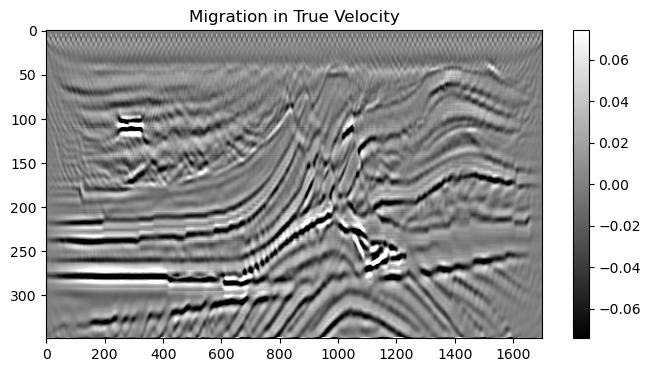

PyObject Text(0.5, 1.0, 'Migration in True Velocity')

In [28]:
mrms1 = 2.5 * sqrt(norm(img1)^2 / length(img1))

figure(figsize=(8,4)); clf()

imshow(img1,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-mrms1,+mrms1);
title("Migration in True Velocity")

## Remove workers

In [29]:
rmprocs(workers())

Task (done) @0x00007f51b3b87a90

In [30]:
time_end = time()
@sprintf("Time to run notebook; %.2f minutes\n", (time_end - time_beg) / 60)

"Time to run notebook; 62.52 minutes\n"